In [1]:
# Importing Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
#reading the data
df = pd.read_csv("sales.csv")

In [3]:
df.head()

,user_id,store_partner,delivery_date,customer_province,gross_basket_delivered,source
0,27791,d25bfabaca150da1296148d555ad5cca,2019-01-28,RM,93.73,Ios-app
1,366484,9d1e8b3eca2a5725245e043f28b92d4d,2019-01-02,VR,72.28,Ios-app
2,717751,91c0f7100bde719c44790e7df757a1a6,2019-01-02,MI,152.69,website
3,1306963,18a5fc43689cfa082c65ee5b7c5eb69b,2019-01-02,BS,49.99,Ios-app
4,551754,d25bfabaca150da1296148d555ad5cca,2019-01-02,RM,23.70,website


In [4]:
df.shape
#df.info()

(173237, 6)

In [5]:
df.duplicated().sum()

19

In [6]:
df = df.drop_duplicates()

In [7]:
# Convert user_id to object data type
df["user_id"] = df["user_id"].astype(object)

# Convert delivery_date to datetime data type
df["delivery_date"] = pd.to_datetime(df["delivery_date"])

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 173218 entries, 0 to 173236
Data columns (total 6 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   user_id                 173218 non-null  object        
 1   store_partner           173218 non-null  object        
 2   delivery_date           173218 non-null  datetime64[ns]
 3   customer_province       173106 non-null  object        
 4   gross_basket_delivered  173218 non-null  float64       
 5   source                  173218 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(4)
memory usage: 9.3+ MB


In [8]:
df["month"] = df["delivery_date"].dt.month
df.groupby(df["delivery_date"].dt.month).sum()

,gross_basket_delivered,month
delivery_date,,
1,1794982.45,30100
2,1736549.82,57508
3,1857631.62,91488
4,1770520.02,114632
5,2060928.80,166855
6,1335302.00,131034


In [9]:
#sources = df.source.unique()
df_may = df.query("month == 5").reset_index()

In [10]:
df_gbd_may = df_may.groupby("delivery_date")["gross_basket_delivered"].sum()

## Outlier detection using MAD

In [11]:
#function to detect outlier using MAD
def outlier_detection_MAD(data,quantile):
    if(hasattr(data, 'to_numpy')): ## Checking if the input is Numpy type or DataFrame type 
        ret = np.array(data.to_numpy(),ndmin=2) ## If not Numpy type: we assume this is a dataframe.
    else:
        ret = data
        
    ## If array of dimension Nx1 or 1xN: Transform the array into a one dimensional vector N        
    if(np.ndim(ret)>1):
        if(np.size(ret,0)<np.size(ret,1)):
            ret = ret.transpose()
        ret = ret[:,0]
    
    ## Discarding the NaN values 
    idx = np.isnan(ret)
    ret = ret[~idx]
    
    ## Computing the median and the MAD
    ret_med = np.median(ret) 
    ret_mad = np.median(np.abs(ret-ret_med))
    
    sigma = 1.48*ret_mad 
    #unc_mean = np.mean(ret)
    #sigma = np.std(ret)
    
    ## Threshold of a standard Normal distribution (1.96 if quantile=0.975)
    thresh = stats.norm.ppf(quantile)
    
    ## Computing lower and upper bounds
    lower_bound = ret_med - (thresh*sigma)
    upper_bound = ret_med + (thresh*sigma)
    
    ## Identifying the outliers
    idx = np.array(ret<lower_bound) + np.array(ret>upper_bound)
    x = np.array(np.arange(0,np.size(ret),1))
    outlier_time = x[idx]
    #temp = outlier_time.transpose()
    return lower_bound,upper_bound,outlier_time

In [12]:
output = outlier_detection_MAD(df_gbd_may, 0.95)
output

(49132.944299745286, 90123.67570025471, array([ 0,  4, 11, 18, 25]))

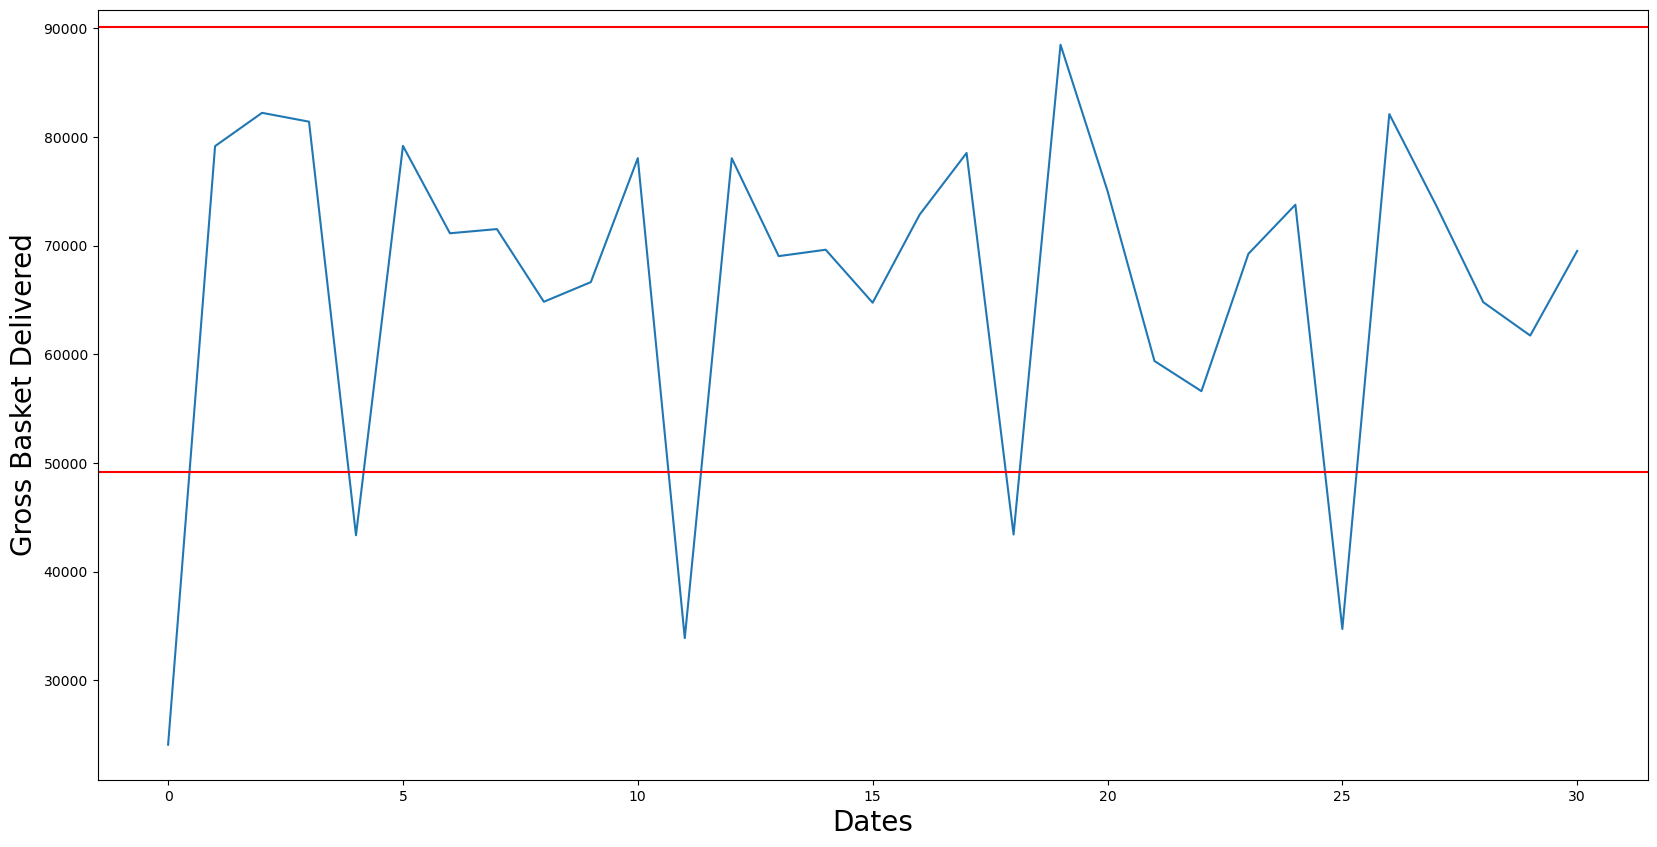

In [13]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.plot(np.arange(df_gbd_may.shape[0]),df_gbd_may)
plt.axhline(y=output[0],linewidth=1.5,color='red')
plt.axhline(y=output[1],linewidth=1.5,color='red')
plt.xlabel("Dates",fontsize=20)
plt.ylabel("Gross Basket Delivered",fontsize=20)
plt.show()

In [14]:
dfd = df.groupby(["delivery_date"]).sum()
output = outlier_detection_MAD(dfd["gross_basket_delivered"], 0.95)
ub = output[1]
lb = output[0]

print(f"Upper Bound : {ub}")
print(f"Lower Bound : {lb}")

Upper Bound : 81225.39471422895
Lower Bound : 51463.30528577106


In [15]:
dfd.drop(columns=["month"],inplace=True)

In [16]:
dfd

,gross_basket_delivered
delivery_date,
2019-01-02,53748.83
2019-01-03,59537.07
2019-01-04,61326.94
2019-01-05,57500.77
2019-01-06,23227.02
...,...
2019-06-16,36258.77
2019-06-17,82472.87
2019-06-18,72674.72


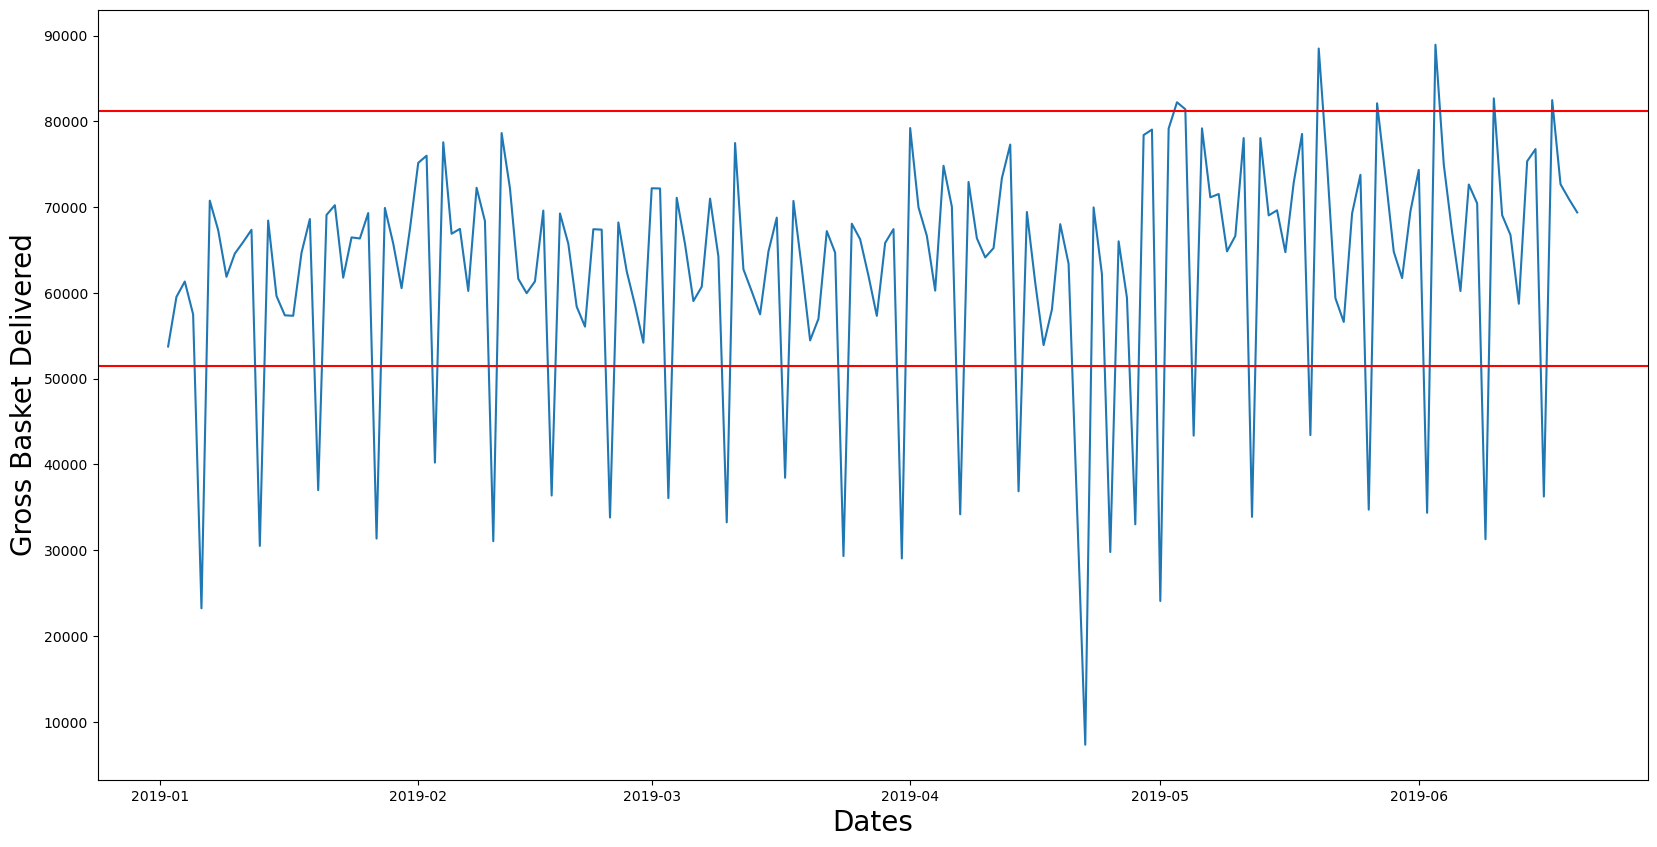

In [17]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.plot(dfd)
plt.axhline(y=lb,linewidth=1.5,color='red')
plt.axhline(y=ub,linewidth=1.5,color='red')
plt.xlabel("Dates",fontsize=20)
plt.ylabel("Gross Basket Delivered",fontsize=20)
plt.show()

In [18]:
df_outliers = dfd[~((lb < dfd['gross_basket_delivered']) & (dfd['gross_basket_delivered'] < ub))]
df_outliers.reset_index(inplace=True)

In [19]:
import warnings
warnings.filterwarnings("ignore")

df_outliers['dow'] = df_outliers['delivery_date'].map(lambda x: x.weekday())
df_outliers['weekday'] = df_outliers['delivery_date'].map(lambda x: 'Y' if x.weekday()<5 else 'N')

In [20]:
df_outliers.head(10)

,delivery_date,gross_basket_delivered,dow,weekday
0,2019-01-06,23227.02,6,N
1,2019-01-13,30502.71,6,N
2,2019-01-20,36999.95,6,N
3,2019-01-27,31357.71,6,N
4,2019-02-03,40214.01,6,N
5,2019-02-10,31054.15,6,N
6,2019-02-17,36375.21,6,N
7,2019-02-24,33816.53,6,N
8,2019-03-03,36075.31,6,N
9,2019-03-10,33250.00,6,N


#### We can observe that on all the Sundays we have lowest deliveries. It can be due to:
    - less/limited delivery personals available for delivery on SUndays
    - Limited grocery stores open during the sundays
    - Even operating stores are open for limited duration (till noon)
##### Hence we can exclude the Sundays for better analysis

In [21]:
df_outliers[~df_outliers["dow"].isin([6])]

,delivery_date,gross_basket_delivered,dow,weekday
15,2019-04-22,7322.14,0,Y
16,2019-04-25,29787.55,3,Y
18,2019-05-01,24078.03,2,Y
19,2019-05-03,82225.44,4,Y
20,2019-05-04,81412.14,5,N
24,2019-05-20,88493.27,0,Y
26,2019-05-27,82107.50,0,Y
28,2019-06-03,88935.34,0,Y
30,2019-06-10,82678.08,0,Y
32,2019-06-17,82472.87,0,Y
